# MinHashing

In [201]:
import os
import mmh3
import numpy as np
import collections
import pandas as pd
from datasketch import MinHash, MinHashLSH
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, LdaModel
from gensim import matutils as genmath, corpora, models
from itertools import tee

DATA_SIZE=50000

### Utilities

In [202]:
#################### Utilities ######################
#hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

''' Extension of standard pairwise function to 3-pairwise from the py standard lib'''
def three_pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    # three_pairwise('ABCDEFG') --> ABC BCD CDE DEF EFG FG
    a, b, c = tee(iterable, 3) ## Create three iterators
    next(b, None) ## Advance the second
    next(c, None) ## Advance the third
    next(c, None) ## Advance the third once again. This ensures the third iterator starts at the third element and that we can create the 3-tuple
    return zip(a, b, c) ### Zip everything (1 elem, 2 elem, and 3 elem) concurrently.

''' Tokenize data and clean using NLTK package'''
stop = set(stopwords.words('english'))
def clean(text):

    tokens = word_tokenize(text)
    # Remove the punctuations, lower tokens and remove stopword
    tokens = [word.lower() for word in tokens if word not in stop and len(word) > 2]
   
    return tokens

### Data preprocessing

In [203]:
''' Load DATA_SIZE amount of data/news articles'''
ROOT_DIR = os.path.abspath(os.curdir)
data = pd.read_csv(ROOT_DIR+"\\data\\articles1.csv")
data_content = data[:DATA_SIZE]["content"] #we are only interested in the content in each news

In [204]:
''' Clean data '''
cleaned_docs=[clean(data) for data in data_content]

''' Create 3-pair shingles'''
def shingle_docs(doc, k=1000):
    
    three_tup=list(three_pairwise(doc))
    three_tup=[elem for elem in three_tup if len(elem)==3]
    return three_tup

''' Listhash a doc, represented by a list of shingles (3-wise) '''
def hash_doc(doc):
    seed=1
    return np.array(sorted([listhash(shingle, seed) for shingle in doc]))

''' Shingle the entire dataset '''
shingled_docs = map(shingle_docs, cleaned_docs)

## Minhashing own implementation

In [206]:
# test_docs=list(zip(["You and me, we made a vow. For better or for worse. I can't believe you let me down",
# "Time, space and state. Equal everything explanable.",
# "You and me, we made a vow. For better or for worse. I can't believe you let me down"]))
seed=1
hashed_shingles=list(map(hash_doc, shingled_docs))
# hashed_shingles=np.array(sorted([listhash(shingle, seed) for shingle in shingled_docs]))
print(len(hashed_shingles))
hashed_shingles=[lst for lst in hashed_shingles if len(lst)>100]
# hashed_shingles
sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000
print(sig_m.shape)

50000
(43985,)


C:\Users\hasee\AppData\Local\Temp\ipykernel_18236\4217812439.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000


In [207]:
lens=min([len(x) for x in sig_m])
print(lens)
num_docs=sig_m.shape[0]
for i in range(num_docs):
    sig_m[i]=sig_m[i][:lens]
sig_m=np.stack(sig_m).T
sig_m.shape

101


(101, 43985)

### LSH implementation

In [208]:
''' Jaccard similarity'''
def jaccard(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

''' Implementation of LSH, dividing signature matrix into b band with r rows each'''
def LSH(sig_m, b, r):
    b=20
    r=5
    #b*r=num_hash_funcs

    sim_hashes=[]
    start=0
    for i in range(b):
        sim_hashes.append([listhash(col, seed=i) for col in sig_m[start:start+r,:].T])
        start=i+r

    return sim_hashes

''' Find candidate pairs by checking to see if the hashes match.
Then we check to see that the Jaccard similarity b/w each pair of docs is atleast t. If so, we consider it a candidate pair otherwise not '''
def get_cand_pairs(sim_hashes, t):
    cand_pairs=set()
    for L in sim_hashes:
        dups = collections.defaultdict(list)
        for i, e in enumerate(L):
            dups[e].append(i)
        for _, v in sorted(dups.items()):
            if len(v) >= 2:
                cand_pairs.add(tuple(v))
    cand_pairs=list(cand_pairs)
    filtered_cand_pairs = [pair for pair in cand_pairs if (jaccard(set(sig_m[:, pair[0]]), set(sig_m[:, pair[1]])) > t)]
    return filtered_cand_pairs
   

In [209]:
b=20
r=5
sim_hashes = LSH(sig_m, b=20, r=5)
pairs=get_cand_pairs(sim_hashes, t=(1/b)**(1/r))
len(pairs)

36

In [210]:
sig_m.shape

(101, 43985)

In [213]:
pairs

[(38900, 38912),
 (41167, 41325),
 (42158, 42321),
 (40096, 40103),
 (8069, 8165),
 (32372, 32434),
 (7992, 28483),
 (13568, 13993),
 (43533, 43547),
 (1158, 29114),
 (42170, 42245),
 (40376, 41766),
 (42431, 42605),
 (13922, 39326),
 (37079, 37140),
 (14829, 22570),
 (43845, 43886),
 (12225, 31584),
 (35740, 35757),
 (8069, 8165, 11474),
 (38995, 39221, 39485),
 (42164, 42322),
 (42904, 42916),
 (17766, 26143),
 (43844, 43885),
 (42905, 42917, 43243),
 (40275, 40408),
 (37948, 38066),
 (18443, 24450),
 (39044, 43675),
 (18292, 26907),
 (41409, 41565),
 (38899, 38911, 39220, 43532),
 (38900, 38912, 38995, 39221, 39485),
 (37099, 37217),
 (43191, 43242)]

## Minhashing using package

In [152]:
num_perm = 100
min_dict1 = {}
count3 = 1
for val in tqdm(shingled_docs):
    m = MinHash(num_perm=num_perm)
    for shingle in val:    
      a= []
      for i in shingle:
        i.encode('utf8')
        a.append(i)
      data1 = str(['_'.join(a)])

      m.update(data1.encode('utf8'))
    min_dict1["m{}".format(count3)] = m
    count3+=1

1000it [00:12, 80.36it/s]


In [153]:
    
lsh = MinHashLSH(threshold=0.54, num_perm=num_perm)
for key in tqdm(min_dict1.keys()):
    lsh.insert(key,min_dict1[key]) # insert minhash data structure

100%|██████████| 1000/1000 [00:00<00:00, 18172.66it/s]


In [154]:
def create_cand_pairs():
    big_list = []
    for query in min_dict1.keys():
        bucket = lsh.query(min_dict1[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

In [155]:
pairs = create_cand_pairs()
pairs1 = [i for i in pairs if i[1] != 'None']

In [156]:
len(pairs1)

2

 We found that there are so many repetitive pairs so that we have to remove those repetitive pairs

In [157]:
pairs1

[['m846', 'm813'], ['m846', 'm813']]

In [158]:
candidate_pairs = []
for i in pairs1:
    if i not in candidate_pairs:
        candidate_pairs.append(i)

In [159]:
len(candidate_pairs)

1

In [160]:
candidate_pairs

[['m846', 'm813']]

# Topic Modeling

In [ ]:
dictionary = corpora.Dictionary()

In [ ]:
#Build a list to store the tokenized words for each document
data_tokenized = []

In [ ]:
#Clean the words in each docuemnt and then add them into the list
for i in data_content.index:  
    cleaned = clean(data_content[i])   
    data_tokenized.append(cleaned)

In [ ]:
dictionary = corpora.Dictionary()

In [ ]:
#We need to pass these tokenized words into dictionary.doc2bow() object
BoW_corpus = [
   dictionary.doc2bow(doc, allow_update=True) for doc in data_tokenized
]

In [ ]:
#Apply the LDA algorithm
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=10)

In [ ]:
#Calculate the topic probality for each document
topic_prob =lda_model.get_document_topics(BoW_corpus ) 

In [ ]:
len(topic_prob)

1000

In [ ]:
#Create a dic to store the topic for each dicument, we take the topic with the biggest probability as the topic of that document.
topic_document = {}
for i in enumerate(topic_prob):
    max = 0
    for j in i[1]:
        if j[1] > max:
            max = j[1]
            topic_document[i[0]] = j[0]

In [ ]:
print(topic_document)

In [ ]:
topic_prob[0]

In [ ]:
topic_num = []
for k,v in topic_document.items():
    topic_num.append(v)

In [ ]:
len(topic_num )

1000

In [ ]:
from collections import Counter
topic_counter = Counter(topic_num)

In [ ]:
topic_counter.most_common()

In [ ]:
topic_num_list = []
for i in range(10):
    topic_num_list.append(topic_counter[i])

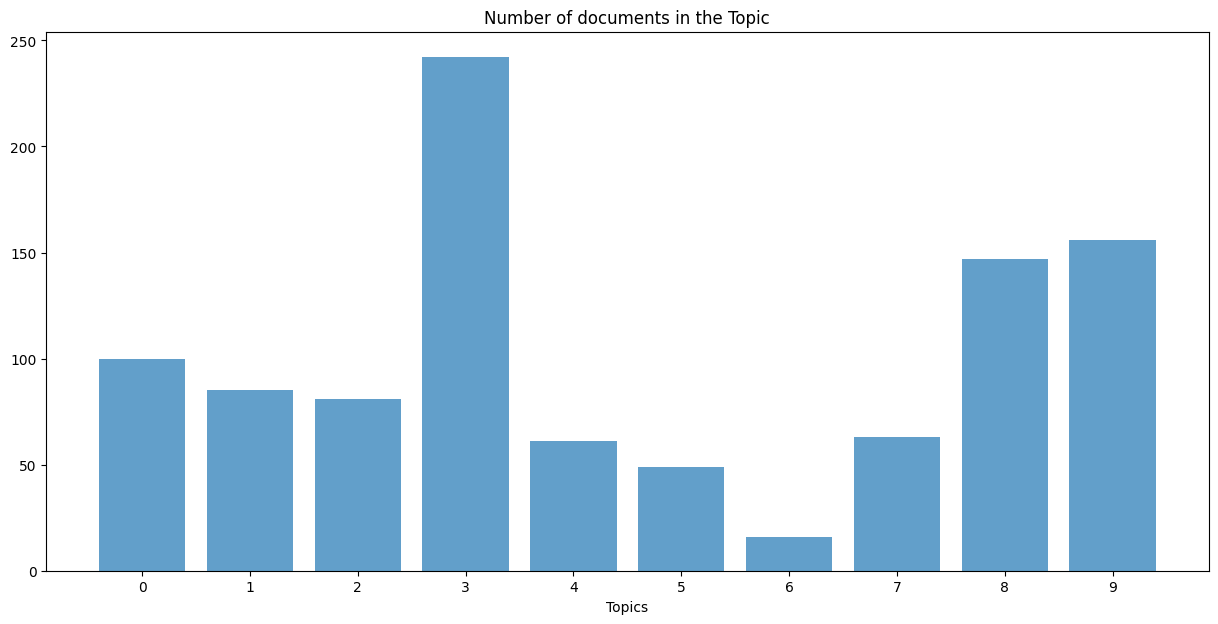

In [ ]:
# coding=utf-8
from matplotlib import pyplot as plt
from matplotlib import font_manager
 
plt.figure(figsize=(15,7)) 
plt.bar(range(10),topic_num_list,align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(range(10),range(10))
plt.xlabel("Topics")
plt.title('Number of documents in the Topic')
plt.show()